In [3]:
from brian2 import *
from scipy.stats import pearsonr
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

# populations
N = 1000  # Total size of population
PC = 0.4
N_E = int(N * 0)  # pyramidal neurons
N_I = int(N * 1)  # interneurons

# voltage
V_L = -70. * mV # Resting potential
V_thr = -52. * mV  # Threshold for firing
V_reset = -59. * mV  # Resest voltage
V_E = 0 * mV  # Reversal potential excitatory
V_I = -70. * mV  # Reversal potential inhibitory

# refractory period
tau_E = 2. * ms
tau_I = 1. * ms

# external stimuli  
C_ext = 800  # Number of inputs
total_input = int(12000 / C_ext)
rate = total_input * Hz

# Membrane time constants for I and E
tau_m_I = 10 * ms
tau_m_E = 20 * ms

# Conductances, I
g_GABA_I = 4 * nS #4
g_AMPA_I = 0.3 * nS # 0.3
g_NMDA_I = 0.1 * nS
g_AMPA_ext_I = 0.4 * nS

# Conductances, E
g_GABA_E = 2.5 * nS
g_AMPA_E = 0.19 * nS
g_NMDA_E = 0.06 * nS

# Time constants for GABA
tau_d_GABA = 5 * ms
tau_r_GABA = 0.5 * ms
tau_l_GABA = 1 * ms

# Time constants for poisson inputs
tau_d_Ext = 2 * ms
tau_r_Ext = 0.4 * ms
tau_l_Ext = 0.5 * ms

# Time constants for AMPA
tau_d_AMPA = 2 * ms
tau_r_AMPA = 0.5 * ms
tau_l_AMPA = 1 * ms

# Time constants for NMDA
tau_d_NMDA = 100 * ms
tau_r_NMDA = 2 * ms
tau_l_NMDA = 1 * ms

# Conductance and Membrane Leak (for correct units)
c_m_I = 0.2 * nF #0.2 * nF
g_m_I = 20 * nS #20. * nS
c_m_E = 0.5 * nF #0.5 * nF
g_m_E = 25 * nS #25. * nS

# g_GABA_I = (g_GABA_I * 0.2)
g_AMPA_ext_I = g_AMPA_ext_I * 1
g_GABA_I = g_AMPA_ext_I * 25  # g_GABA_I * 1
c_m_I = c_m_I * 1
g_m_I = g_m_I * 1

eqs_I = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_Ext + I_GABA_t: amp 

I_GABA_t = (I_GABA_decay - I_GABA_rise) : amp
I_Ext = (I_Ext_decay - I_Ext_rise) : amp

I_GABA_decay =  g_GABA_I * (v - V_I) * s_GABA_d : amp
I_GABA_rise =  g_GABA_I * (v - V_I) * s_GABA_r : amp

ds_GABA_r/dt = - s_GABA_r / tau_r_GABA : 1
ds_GABA_d/dt = - s_GABA_d / tau_d_GABA : 1

I_Ext_decay =  g_AMPA_ext_I * (v - V_E) * s_Ext_d : amp
I_Ext_rise =  g_AMPA_ext_I * (v - V_E) * s_Ext_r : amp
ds_Ext_r/dt = - s_Ext_r / tau_r_Ext : 1
ds_Ext_d/dt = - s_Ext_d / tau_d_Ext : 1
'''

# eqs_E = '''
# dv / dt = (-g_m_E * (v - V_L) - I_syn) / c_m_E : volt (unless refractory)

# I_syn = I_GABA + I_AMPA + I_NMDA: amp

# I_GABA = g_GABA_E * (v - V_I) * s_GABA : amp
# I_AMPA = g_AMPA_E * (v - V_E) * s_AMPA : amp
# I_NMDA = g_NMDA_E * (v - V_E) * s_NMDA : amp

# ds_GABA / dt = (tau_m_E / (tau_d_GABA - tau_r_GABA)) * 
#                 (-exp(Gd) / tau_d_GABA + 
#                 exp(Gr)/ tau_r_GABA) : 1 
# dGr / dt = - s_GABA / tau_r_GABA : 1
# dGd / dt = - s_GABA / tau_d_GABA : 1

# ds_AMPA / dt = (tau_m_E /(tau_d_AMPA - tau_r_AMPA)) * 
#                (-exp(Ad)/tau_d_AMPA + 
#                 exp(Ar)/tau_r_AMPA) : 1 
# dAr / dt = - s_AMPA / tau_r_AMPA : 1
# dAd / dt = - s_AMPA / tau_d_AMPA : 1

# ds_NMDA / dt = (tau_m_E /(tau_d_NMDA - tau_r_NMDA)) * 
#                (-exp(Nd)/tau_d_NMDA + 
#                exp(Nr)/tau_r_NMDA) : 1  
# dNr / dt = - s_NMDA / tau_r_NMDA : 1
# dNd / dt = - s_NMDA / tau_d_NMDA : 1          
# '''

P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_I, method='euler')
# P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_E, method='euler')

pre_GABA = '''
s_GABA_r += 1
s_GABA_d += 1
'''

pre_AMPA= '''
s_AMPA_r += 1
s_AMPA_d += 1
'''

pre_NMDA= '''
s_NMDA_r += 1
s_NMDA_d += 1
'''

pre_Ext= '''
s_Ext_r += 1
s_Ext_d += 1
'''

#P_E_I = PoissonGroup(C_ext, rate)
C_P_R = PoissonInput(P_I, 's_Ext_r', C_ext, rate, '0.2')
C_P_D = PoissonInput(P_I, 's_Ext_d', C_ext, rate, '1')
# C_P_E = PoissonInput(P_E, 's_AMPA', C_ext, rate, '1')

P_I.v = V_L
C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
#C_P_I = Synapses(P_E_I, P_I, on_pre=pre_Ext, method='euler', delay=tau_l_Ext)
# C_I_E = Synapses(P_I, P_E, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_I.connect(condition='i != j', p=PC)
#C_P_I.connect()
# C_I_E.connect(p=0.2)

s_I = SpikeMonitor(P_I)
# s_E = SpikeMonitor(P_E[:20])
M = StateMonitor(P_I, ('v', 'I_GABA_t', 'I_Ext'), record=True)
p_I = PopulationRateMonitor(P_I)
# p_E = PopulationRateMonitor(P_E)

# net = Network(P_I, P_E, C_P_E, C_P_I, C_I_I, C_I_E, s_I, p_I, s_E, p_E)
net = Network(P_I, C_P_R, C_P_D, C_I_I, s_I, p_I, M)
net.run(2.5 * second, report='stdout')


Starting simulation at t=0. s for a duration of 2.5 s
2.5 (100%) simulated in 4s


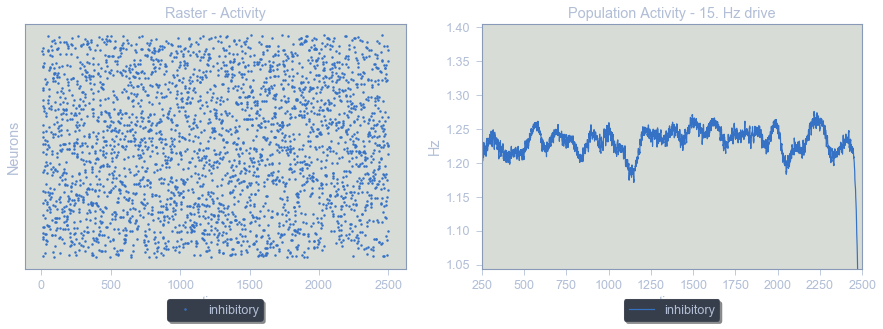

In [4]:
figure(figsize=(15, 5))
subplot(121)
# plt.plot(s_E.t / ms, (s_E.i + 20)*0.025, 'r.', markersize=5, label='exitatory')
plt.plot(s_I.t / ms, s_I.i*0.025, 'b.', markersize=5, label='inhibitory')
title('Raster - Activity')
xlabel('ms')
yticks([])
xlabel('time')
ylabel('Neurons')
# xticks([516, 517, 518])
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

subplot(122)
# plt.plot(p_E.t / ms, p_E.smooth_rate(width=25 * ms) / Hz, 'r-', label='exitatory')
plt.plot(p_I.t / ms, p_I.smooth_rate(width=25 * ms) / Hz, 'b-', label='inhibitory')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
title('Population Activity - ' + str(rate) + ' drive')
xlabel('ms')
xlabel('time')
ylabel('Hz')
p_I_mean = np.mean(p_I.smooth_rate(width=25 * ms) / Hz)
p_I_std = np.std(p_I.smooth_rate(width=25 * ms) / Hz)
ylim((p_I_mean - 3*p_I_std, p_I_mean + 3*p_I_std))
xlim([250, 2500])
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)